Processing fasta files: 100%|██████████| 2317/2317 [00:00<00:00, 13345.13it/s]


Longest sequence: ID = 6HRM_1_1, Length = 4417
Shortest sequence: ID = 4AM3_1_I, Length = 1
Average sequence length: 573.51
Median sequence length: 76.00


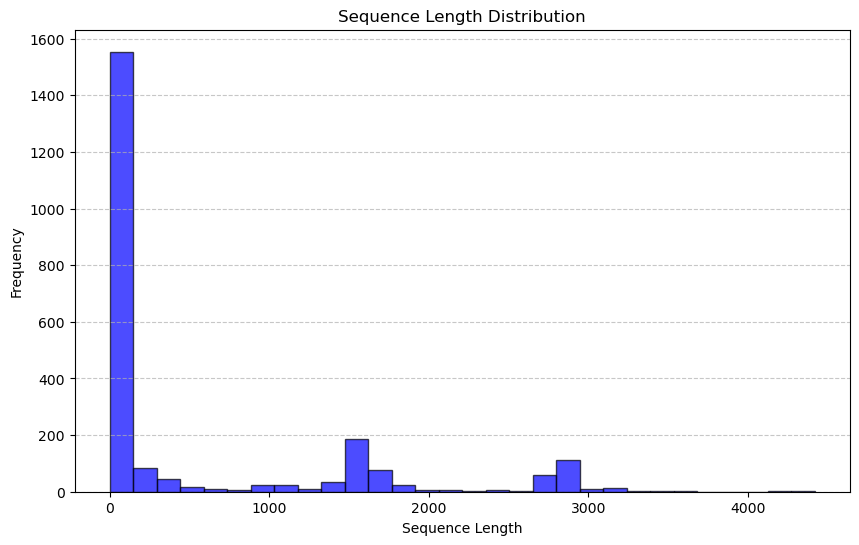

In [7]:
from rnampnn.utils.data import analyse_dataset

analyse_dataset()

In [1]:
from rnampnn.utils.data import RNADataModule

data = RNADataModule()
data.setup(stage="fit")

Initializing dataset: 100%|██████████| 2317/2317 [00:03<00:00, 743.20it/s]


In [2]:
train = data.train_dataloader()
for i in train:
    print(i)
    break

(tensor([[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]), tensor([[[[217.6020, 257.9880, 140.2690],
          [218.3050, 256.6860, 140.8530],
          [217.9200, 256.1760, 142.1230],
          ...,
          [217.7460, 253.9820, 140.8140],
          [218.5100, 252.7810, 140.7920],
          [214.7400, 253.3310, 142.8580]],

         [[220.01

In [1]:
from rnampnn.utils.data import RNADataset

dataset = RNADataset.from_path("data/")


Initializing dataset: 100%|██████████| 2317/2317 [00:03<00:00, 751.01it/s]


In [2]:
print(len(dataset))
dataset.slice_augmentation(num_gen=100)
print(len(dataset))

2317
2417


In [1]:
from rnampnn.utils.data import pdb_to_coords

pdb_to_coords("data/pdb", "data/")